In [ ]:
%%capture
from scipy.signal import resample
!pip install braindecode===0.7
from google.colab import drive
drive.mount('/content/drive')
!pip install --upgrade tensorflow
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

In [ ]:
from src.prediction.Model_Control.Global_Class.Global_Class import ModelControl
from src.prediction.Model_Control.Global_Class.Global_Class import DatasetControl

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


##ADECUAMOS LOS MODELOS

In [ ]:
###PROBAMOS LOS SUJETOS
#acc_subj = []

#### OBTENEMOS LOS CALLBACKS NECESARIOS
callbacks_names = {'early_stopping_train1':'early_stopping','checkpoint_train1':'checkpoint',
                   'early_stopping_train2':'early_stopping','checkpoint_train2':'checkpoint',
                   'early_stopping_train3':'early_stopping','checkpoint_train3':'checkpoint',
                   'early_stopping_train4':'early_stopping','checkpoint_train4':'checkpoint'}

subjects = [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52]

datasetControl = DatasetControl(DatasetName='GIGA') ### DEFINIMOS LA BASE DE DATOS
### OBTENEMOS LAS SESIONES Y RUNS DE LA BASE DE DATOS SELECCIONADA
sessionsRuns = datasetControl.getSessionsRuns()
#Acc__subs_runs = []

In [ ]:
from braindecode.datasets.moabb import MOABBDataset
from braindecode.preprocessing.preprocess import (exponential_moving_standardize, preprocess, Preprocessor, scale)
from braindecode.preprocessing.windowers import create_windows_from_events
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as md

Hacemos min max scaler y hacemos cluster con los resultados tomando cada run como una caracteristica

In [ ]:
%%capture
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.signal import resample
!pip install braindecode===0.7
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tf_keras_vis
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install gcpds.utils
import pickle
import os
import time
import gc

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Circle
from gdown import download_folder, download
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import cohen_kappa_score, roc_auc_score
from scipy.signal import freqz, filtfilt
from scipy.signal import butter as bw
from scipy.stats import ks_2samp
from scipy.spatial.distance import squareform, cdist
from tf_keras_vis import layercam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore, InactiveScore
from gcpds.databases import GIGA_MI_ME
from gcpds.databases.BCI_Competition_IV import Dataset_2a
from scipy.signal import resample

## MIRAMOS CAMS

In [ ]:
class LayerCamNoSum(layercam.Layercam):
    def _calculate_cam(self, grads, penultimate_output, gradient_modifier, activation_modifier):
        if gradient_modifier is not None:
            grads = gradient_modifier(grads)
        cam = np.multiply(penultimate_output, grads)
        if activation_modifier is not None:
            cam = activation_modifier(cam)
        return cam

### MATEO METHODS

def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true,y_pred)

def minmax_norm(x):
    x = x - np.min(x)
    x = x/np.max(x)
    return x

def bi_class_data(x,y):
    # Define la condición para eliminar valores del segundo arreglo
    condicion = y > 1  # Por ejemplo, eliminar valores mayores que 0.5

    # Encuentra las posiciones donde la condición es True en el segundo arreglo
    posiciones_a_eliminar = np.where(condicion)

    # Elimina los valores en las posiciones encontradas en el segundo arreglo
    y_2 = np.delete(y, posiciones_a_eliminar)

    # Elimina los mismos valores en las mismas posiciones en el primer arreglo
    X_2 = np.delete(x, posiciones_a_eliminar, axis=0)

    return X_2,y_2

In [ ]:
mpl.style.use('default')

##cargamos la información de cada sujeto los datos con los que lo entrenamos

In [ ]:
acc_subj_MTVAE =  [89.0,66.5,98.0,90.0,99.0,84.0,72.0,79.5,77.5,90.5,73.5,75.5,96.5,98.0,83.5,76.5,78.5,78.0,80.5,75.0,63.5,82.0,95.5, 78.0,87.0,96.5,78.5,90.0,81.0,78.0,79.0,79.0,70.5,85.5,78.0,87.0,66.5,80.0,77.5,96.0,79.5,94.0,95.0,75.0,83.0,96.0,100.0,76.5,78.5]

In [ ]:
#subject = 43
Acc_array_mtvae = np.array(acc_subj_MTVAE ) / 100

In [ ]:
subjects = [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52]

In [ ]:
subjects_str = ['1','2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
 '26', '27', '28', '29', '30', '31', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '47', '48', '50', '51', '52']

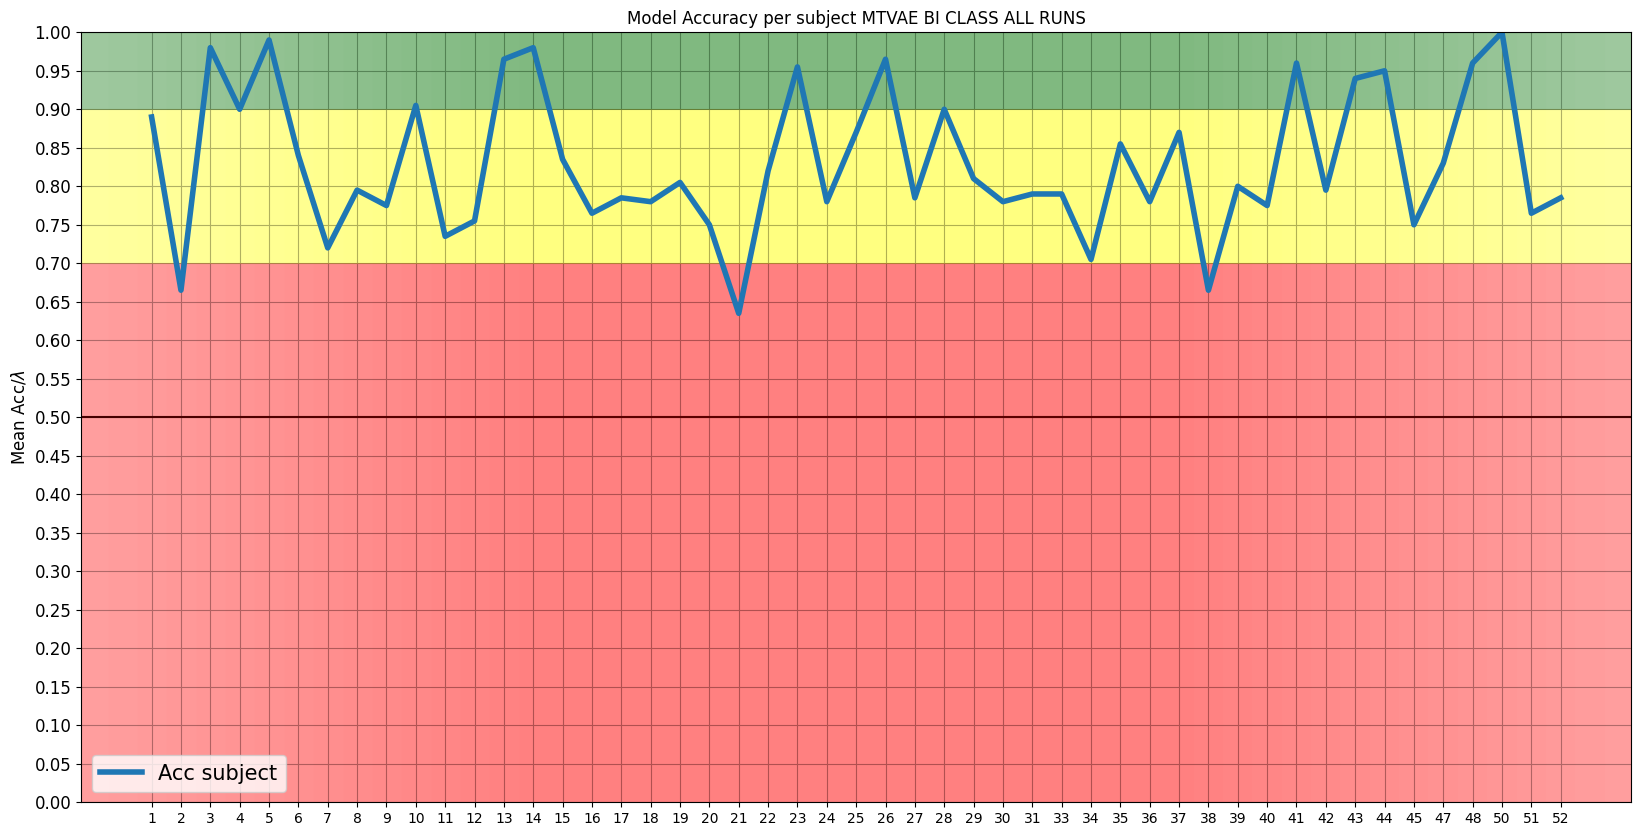

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.grid(True)
plt.axhline(0.5, color='black') # 0.5 is the baseline for 2-class accuracy

plt.vlines(subjects_str, 0.0, 0.7, alpha = 0.01, linewidth = 1500, color = 'red') # Color the red region for accuracies below 0.6
plt.vlines(subjects_str, 0.7, 0.9, alpha = 0.01, linewidth = 1500, color = 'yellow') # Color the yellow region for accuracies between 0.8 and 0.6
plt.vlines(subjects_str, 0.9, 1.0, alpha = 0.01, linewidth = 1500, color = 'green') # Color the green region for accuracies above 0.8

plt.plot(subjects_str,Acc_array_mtvae, label = 'Acc subject', linewidth = 4) # Plot the best mean accuracies


plt.yticks(np.arange(0.0, 1.05, 0.05), fontsize='12') # Make sure the ticks have a 0.05 increment up to 1.0
plt.ylabel('Mean Acc/$\lambda$', fontsize='12')
plt.ylim(0.0,1.0)
plt.title('Model Accuracy per subject MTVAE BI CLASS ALL RUNS')
plt.legend(fontsize='15')
plt.show()

CARGAMOS LA BASE DE DATOS

In [ ]:
#### CARGAMOS DATOS DEL MODELO STANDAR DE CLASIFICACIÓN
y_data_total = np.array(pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/y_clasification.pkl', 'rb')))
x_data_total = np.array(pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/x_clasification.pkl', 'rb')))

calculamos metricas

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_A(coord: np.ndarray, images: np.ndarray, zoom: float, cmap: str, grs_id: np.ndarray, group_colors, ax):
  for i in range(coord.shape[0]):
      im = OffsetImage(images[i], zoom = zoom, cmap = cmap)
      ab = AnnotationBbox(im, (coord[i,0], coord[i,1]), pad = 0.2, bboxprops = dict(edgecolor = group_colors[str(grs_id[i])], lw = 2))
      ax.add_artist(ab)
      ax.update_datalim([(coord[i,0], coord[i,1])])
      ax.autoscale()
  return ax

In [ ]:
channels = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1','Cz', 'C2',
            'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz','P2', 'POz']


def triu(X):
    ones = tf.ones_like(X[0,...]) #(C, C)
    mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
    mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
    mask = tf.cast(mask_a - mask_b, dtype = tf.bool) #Make a bool mask (C, C)
    return tf.boolean_mask(X, mask, axis = 1) #(N, F, C*(C-1)/2)

def ks_connetivity_cal(A, y):
  D = A.shape[-1]
  ks = np.zeros(D)
  pvalue = np.zeros(D)
  for d in range(D):
    ks[d], pvalue[d] = ks_2samp(A[y == 0][:, d], A[y == 1][:, d], alternative = 'two-side', mode = 'auto')
  return ks, pvalue

def get_pred_labels(preds):
        pred_labels = np.argmax(preds,axis=-1)
        return pred_labels

def get_accuracy(preds,y_true,decimals=2):
    pred_labels = get_pred_labels(preds)
    acc = np.mean(pred_labels==np.argmax(y_true,axis = -1 ))
    return np.round(acc*100,decimals=decimals)

In [ ]:
# Now we want to know which hyper parameter produced the best model
# Once we know this we can load that model from the models folder

AA = {} ## diccionarios
C = 64

cam = {} ## cams
metri = [] ### arreglo de metricas

r_list = []
k_list = []
auc_list = []


start_time = time.time()
for sbj in subjects[:46]:
    index = subjects.index(sbj)
    X_train, y_train = x_data_total[index],y_data_total[index]
    ### CARGAMOS LA BASE DE DATOS BCI2A Y EEGNET
    print(X_train[0].shape[1],X_train[0].shape[2],X_train.shape)
    model_args = {'nb_classes':2,'Chans':X_train[0].shape[0],'Samples':X_train[0].shape[1],'dropoutRate':0.5}
    modelControl = ModelControl(Model = 'MTVAE_with_loss',parameters = model_args )

    # ###COMPILAMOS EL MODELO
    modelControl.compileModel(optimizer='Adam',lr=0.001,loss_list=['mse','categorical_crossentropy'],metrics = ['accuracy'])

    filepath = '/content/drive/MyDrive/EEG_DATA/MTVAE_ALL_RUNS/'+'checkpoint4_'+str(subjects[index])
    modelControl.Model.load_weights(filepath)
    results = modelControl.Model.predict(X_train)
    #### CALCULAMOS METRICAS
    Acc = Acc_array_mtvae[index]
    r = Acc
    # k = 1 - kappa(y_valid, np.argmax(results,axis = 1))
    # auc = roc_auc_score(y_valid, np.argmax(results,axis = 1))

    r_list.append(Acc)
    # k_list.append(k)
    # auc_list.append(auc)
    print("RESULTADOS METRICAS");



448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 63ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 57ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 60ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 59ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 60ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 57ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 57ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 57ms/step
RESULTADOS M

7/7 [==============================] - 1s 58ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 57ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 61ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 58ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 55ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 62ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 59ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 62ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITO

7/7 [==============================] - 3s 58ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 59ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 59ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 59ms/step
RESULTADOS METRICAS
448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 1s 64ms/step
RESULTADOS METRICAS


## GENERAMOS EL CLUSTER POR MODELO

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install mne
!pip install pickle5
!pip install gcpds.utils
!pip install scikeras[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.4 MB/s eta 0:00:00
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 2.8 MB/s eta 0:00:00
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
from scipy.spatial.distance import squareform
import os
# tensorlfow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, AveragePooling2D, BatchNormalization, Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import L1L2

# scikeras
#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score
from sklearn.manifold import TSNE
# freq filter
#from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr

#EEG montage
from gcpds.utils.mne_handler import get_best_montage

# general
import numpy as np
from scipy.signal import resample
# import pickle5 as pickle
import warnings
import mne
from time import time

In [ ]:
def ks_connetivity_cal(A,y):
    D=A.shape[-1]
    ks = np.zeros(D)
    pvalue = np.zeros(D)
    for d in range(D):
        ks[d],pvalue[d]=ks_2samp(A[y==0, d], A[y==1, d], alternative = 'two-side', mode = 'auto')
    return ks,pvalue

In [ ]:
n_runs = 46
eegnet_scores = np.zeros((n_runs,3)) ##

kernel_time_ = np.zeros((n_runs))
Nfilters_ = np.zeros((n_runs))

In [ ]:
runs = np.array(list(map(int,subjects_str[:46])))

In [ ]:
runs.shape

(46,)

In [ ]:
C = 64 ## CHANNELS
ks = np.zeros((runs.shape[0], 360))
pvalue = np.zeros((runs.shape[0], 360))

In [ ]:
for idx,sbj in enumerate(runs):

    index = subjects.index(sbj)
    X_train, y_train = x_data_total[index],y_data_total[index]
    ### CARGAMOS LA BASE DE DATOS BCI2A Y EEGNET
    print(X_train[0].shape[1],X_train[0].shape[2],X_train.shape)
    model_args = {'nb_classes':2,'Chans':X_train[0].shape[0],'Samples':X_train[0].shape[1],'dropoutRate':0.5}
    modelControl = ModelControl(Model = 'MTVAE_with_loss',parameters = model_args )

    # ###COMPILAMOS EL MODELO
    modelControl.compileModel(optimizer='Adam',lr=0.001,loss_list=['mse','categorical_crossentropy'],metrics = ['accuracy'])

    filepath = '/content/drive/MyDrive/EEG_DATA/MTVAE_ALL_RUNS/'+'checkpoint4_'+str(subjects[index])
    modelControl.Model.load_weights(filepath)
    layer_name='bottleneck'
    FC_layer = Model(inputs=modelControl.Model.input,
                                  outputs=modelControl.Model.get_layer(layer_name).output)

    fc_layer_pred = FC_layer.predict(X_train)
    fc_layer_pred = fc_layer_pred[:199].reshape(199, -1)
    ks[idx],pvalue[idx] = ks_connetivity_cal(fc_layer_pred,y_train[:199])

    ent = pvalue[idx].mean()#-np.log(np.trace(np.dot(pValueMatrix,pValueMatrix.T)))
    ksEnt = ks[idx].mean()#-np.log(np.trace(np.dot(ksMatrix,ksMatrix.T)))

    eegnet_scores[idx, -2] = ent #por que en eegnet?
    eegnet_scores[idx, -1] = ksEnt #por que en eegnet?
    eegnet_scores[idx, -3] = r_list[index]

448 1 (200, 64, 448, 1)
MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 18ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 18ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 17ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE


7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 17ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE


7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 18ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 16ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step
448 1 (200, 64, 448, 1)


MODELO COMPILADO EXITOSAMENTE
7/7 [==============================] - 0s 15ms/step


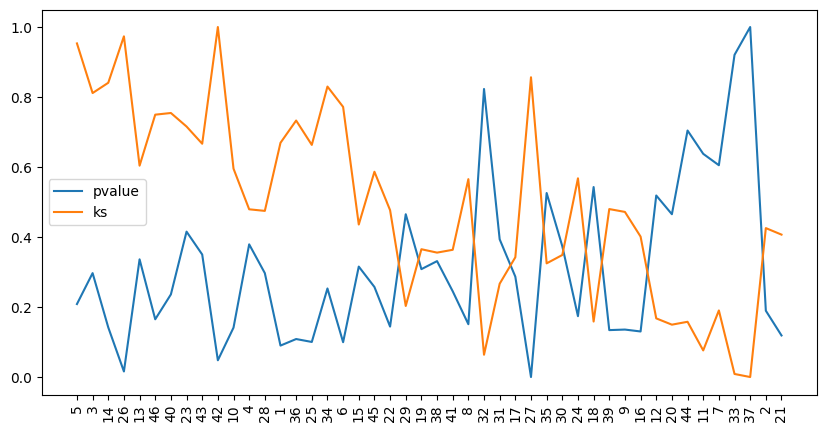

In [ ]:
import matplotlib.pyplot as plt
sca_ = MinMaxScaler()
gfcnet_scores_ =sca_.fit_transform(eegnet_scores)

#plt.pcolormesh(gfcnet_scores_)
#plt.colorbar()
#plt.show()

fig = plt.figure(figsize=(10,5))
ind_ = np.argsort(eegnet_scores[:,0])[::-1]
# plt.plot(gfcnet_scores_[ind_,0],label='ACC')
plt.plot(gfcnet_scores_[ind_,-2:],label=['pvalue','ks'])
plt.legend()
plt.xticks(ticks=np.arange(eegnet_scores.shape[0]),labels=ind_+1,rotation=90)
plt.show()

In [ ]:
from scipy.spatial.distance import cdist, squareform
from sklearn.cluster import DBSCAN, KMeans

from seaborn import kdeplot
import pandas as pd

In [ ]:
min_samples = 45 ## interpretación?
scaZ = MinMaxScaler()
red_ = TSNE(n_components=2, random_state=42, perplexity = min_samples)
Z_ = scaZ.fit_transform(red_.fit_transform(gfcnet_scores_))

In [ ]:
D_ = cdist(gfcnet_scores_,gfcnet_scores_)
eps_ = np.percentile(squareform(D_), 5)
print(eps_)

0.1379976970085638


In [ ]:
grupo1 = [5,43,26,3,14,23,35,4,44,13]
grupo2 = [1,21,10,39,48,36,27,41,8,18,31,22,24,37,47,20,29,2]
grupo3 = [19,16,7,30,33,38,40,17,45,11,9,6,28,42,34]

In [ ]:
Z_1  = []
Z_2  = []
Z_3  = []

for sbj in subjects:
    index =  subjects.index(sbj)
    if sbj in grupo1:
       Z_1.append(Z_[index])
    elif sbj in grupo2:
       Z_2.append(Z_[index])
    elif sbj in grupo3:
       Z_3.append(Z_[index])

Z_1 = np.array(Z_1)
Z_2 = np.array(Z_2)
Z_3 = np.array(Z_3)

In [ ]:
import seaborn as sns

In [ ]:
%%capture
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
! sudo apt install cm-super

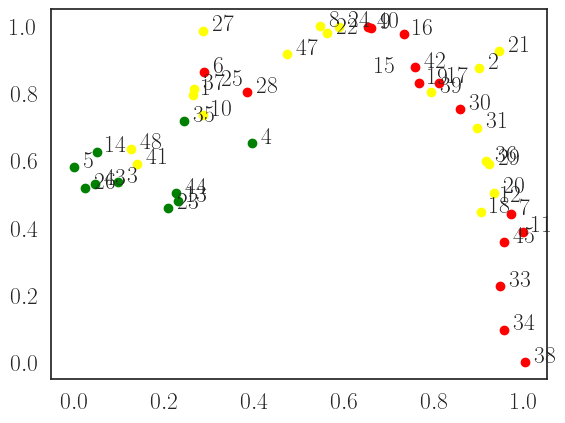

In [ ]:
fs = 17
fs_b = 22
fs_tkz = 15
sns.set(style='white')
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('font', size=fs)
plt.scatter(Z_1[:, 0], Z_1[:, 1], c='green', label=f'Grupo {1}')
plt.scatter(Z_2[:, 0], Z_2[:, 1], c='yellow', label=f'Grupo {2}')
plt.scatter(Z_3[:, 0], Z_3[:, 1], c='red', label=f'Grupo {3}')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
for i in range(len(runs)):
     plt.annotate(runs[i], (Z_[i, 0]+0.02, Z_[i, 1]))
plt.show()

In [ ]:
acc_subj_EEGNET = [88.0,61.0,96.0,93.5,95.0,82.0,64.17,66.0,62.08,77.5,71.0,78.5,94.0,97.0,88.0,75.0,60.5,63.5,73.5,76.0,57.0,67.0,92.5,83.5,70.5,98.5,73.5,85.5,73.5,63.5,80.0,75.5,74.0,86.0,83.0,75.0,72.0,75.5,68.0,91.5,73.5,92.0,88.5,73.5,77.5,94.0,98.5,61.5,71.5]

In [ ]:
seed=23
n_groups = 3 ## HACEMOS LOS GRUPOS
clus = kmeans = KMeans(n_clusters = n_groups, random_state = seed) #DBSCAN(eps=eps_,min_samples = min_samples)

clus.fit(Z_)
gfcnet_labels = clus.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


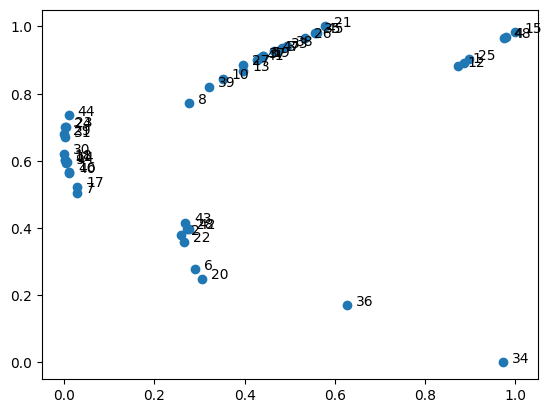

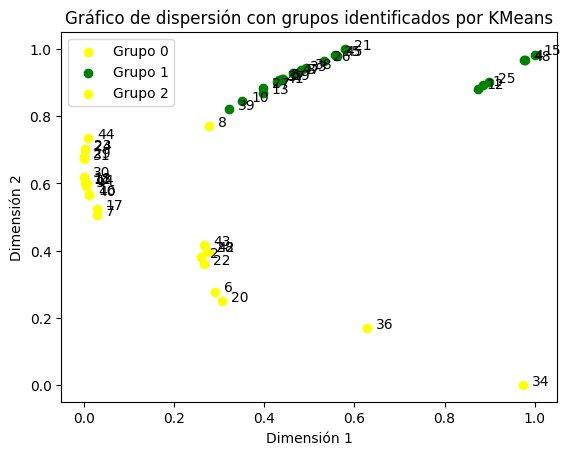

In [ ]:
plt.scatter(Z_[:,0],Z_[:,1])

# Añade las etiquetas
for i in range(len(runs)):
    plt.annotate(runs[i], (Z_[i, 0]+0.02, Z_[i, 1]))

plt.show()
# Define los colores que se utilizarán en el gráfico
colors = ['yellow','green','red']

for i, label in enumerate(set(gfcnet_labels)):
    # Obtiene los índices de los puntos que pertenecen al grupo actual
    indices = gfcnet_labels == label

    # Grafica los puntos del grupo actual en el scatter plot
    # if (label == 0):
    #    data = 'Regular'
    # elif (label ==1):
    #    data = 'Buenos'
    # else:
    #    data = 'malos'
    plt.scatter(Z_[indices, 0], Z_[indices, 1], c=colors[i % len(colors)], label=f'Grupo {label}')
    # for indice in indices:
    #     plt.text(Z_[indice, 0], Z_[indice, 1], str(n_sbj[indice]), fontsize=8)
# Configura los ejes y la leyenda
# Añade las etiquetas
for i in range(len(runs)):
    plt.annotate(runs[i], (Z_[i, 0]+0.02, Z_[i, 1]))
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.legend()
plt.title('Gráfico de dispersión con grupos identificados por KMeans')
plt.show()

In [ ]:
from typing import Dict
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.colors as mcolors

def plot_tsne(coord: np.ndarray, images: np.ndarray, zoom: float, cmap: str, grs_id: np.ndarray, group_colors: Dict[str, str], ax):
    for i in range(coord.shape[0]):
        im = OffsetImage(images[i], zoom = zoom, cmap = cmap)
        ab = AnnotationBbox(im, (coord[i,0]+0.3, coord[i,1]), pad = 0.2,
                            bboxprops = dict(edgecolor = group_colors[str(grs_id[i])], lw = 2))
        ax.add_artist(ab)
        ax.update_datalim([(coord[i,0], coord[i,1])])
        ax.autoscale()
    return ax


def plot_tsne_v2(coordx: np.ndarray,coordy:np.ndarray, images: np.ndarray, zoom: float, cmap: str, grs_id: np.ndarray, group_colors: Dict[str, str], ax):
    for i in range(coordx.shape[0]):
        im = OffsetImage(images[i], zoom = zoom, cmap = cmap)
        # Creamos el cuadro de anotación con la imagen
        ab = AnnotationBbox(im, (coordx[i], coordy[i]),  pad = 0.2,
                            bboxprops = dict(edgecolor = group_colors[str(grs_id[i])], lw = 2))
        # Agregamos el cuadro de anotación al eje
        ax.add_artist(ab)
    return ax

def plot_tsne_points(coord: np.ndarray, grs_id: np.ndarray, ax):
    base_colors = mcolors.BASE_COLORS
    tab_colors = mcolors.TABLEAU_COLORS

    try:
        del base_colors['w']
    except:
        pass

    colors = dict(base_colors)
    colors.update(tab_colors)

    group_colors = {}

    for idx, grs in enumerate(np.unique(grs_id)):
        group_colors[grs] = list(colors.keys())[idx]

    unique_values = list(np.unique(grs_id))

    for i in range(coord.shape[0]):
#         if (grs_id[i] in unique_values):
#             ax.scatter(coord[i,0], coord[i,1], color = f'{group_colors[grs_id[i]]}', label = grs_id[i])
#             unique_values.remove(grs_id[i])
#         else:
#             ax.scatter(coord[i,0], coord[i,1], color = f'{group_colors[grs_id[i]]}')

        ax.scatter(coord[i,0], coord[i,1])

        ax.update_datalim([(coord[i,0], coord[i,1])])
        ax.autoscale()
    return ax

In [ ]:
import matplotlib.patches as mpatches


#groups_colors = {'0':'tab:green', '1':'tab:red'}
#men_patch = mpatches.Patch(color = 'tab:green', label = "Men's group")
#women_patch = mpatches.Patch(color = 'tab:red', label = "Women's group")

groups_colors = {'2':'green', '1':'yellow', '0':'red'}
good_patch = mpatches.Patch(color = 'green', label = "good group")
med_patch = mpatches.Patch(color = 'yellow', label = "med group")
bad_patch = mpatches.Patch(color = 'red', label = "bad group")
my_GFC_tsne = Z_
Z_.shape

(46, 2)

In [ ]:
indices_ordenados = np.argsort(acc_subj_MTVAE[:46])[::-1]

In [ ]:
eegnet_acc_ordenado = np.array(acc_subj_MTVAE)[indices_ordenados]
subjects_str_ordenados = np.array(subjects)[indices_ordenados]
pvalue_ordenado =pvalue[indices_ordenados]

In [ ]:
C=64
dims = int(C*(C-1)/2)

In [ ]:
from mne.channels import make_standard_montage ,get_builtin_montages
from mne.viz import plot_topomap , plot_montage
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

In [ ]:
import matplotlib as mpl

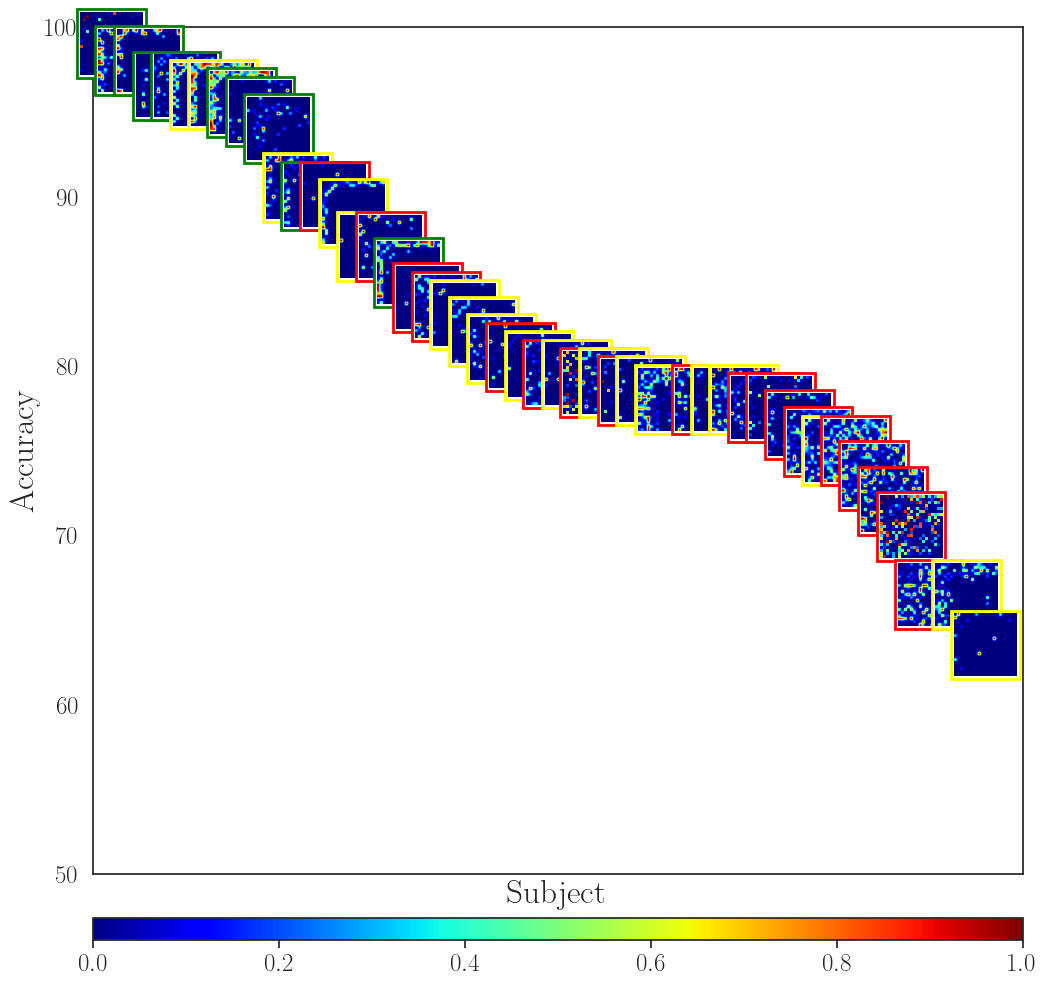

In [ ]:
fs = 24
fs_b = 22
fs_tkz = 18
sns.set(style='white')
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('font', size=fs)
acc_disc = np.zeros(70,dtype=int)

# for i in range(len(r_list)):
#     if (np.array(eegnet_acc_ordenado)/100)[i] >= 0.80:
#         acc_disc[i] = 2
#     elif ((np.array(eegnet_acc_ordenado)/100)[i]>= 0.70) and ((np.array(eegnet_acc_ordenado)/100)[i]<0.80):
#          acc_disc[i] = 1
# acc_disc = list(acc_disc)

for i in range(len(r_list)):
    sbj  =  subjects_str_ordenados[i]
    if sbj in grupo1:
        acc_disc[i] = 2
    elif sbj in grupo2:
         acc_disc[i] = 1
acc_disc = list(acc_disc)

fig, ax = plt.subplots(nrows = 1,ncols = 1 ,figsize = (12, 11))
ax = plot_tsne_v2(np.array(subjects[:46]),np.array(eegnet_acc_ordenado) ,np.asarray([squareform(triu[:210]) for triu in pvalue_ordenado]), 2.15, 'jet', acc_disc, groups_colors, ax)
# ax.set_xlabel(r'$z_{1}$', fontsize = 15)
# ax.set_ylabel(r'$z_{1}$', fontsize = 15)
# plt.legend(handles = [good_patch, med_patch], prop = {'size': 15})
# for i in range(len(runs)):
#     plt.annotate(runs[i], (Z_[i, 0]+0.04, Z_[i, 1]))
plt.savefig('groups.png')
plt.xlim(0,50)
plt.xticks([])
plt.yticks(size = fs_tkz)
plt.ylim(50,100)
plt.ylabel('Accuracy',size=fs)
plt.xlabel('Subject',size=fs)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)
# Resize the top-left subplot
#ax[1].set_constrained_layout(True)
ax2 = fig.add_axes([0.125, 0.05, 0.775, 0.02])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='horizontal')
ax2.tick_params(axis='x', labelsize=fs_tkz)
plt.show()

In [ ]:
Cho2017_Channels=[
                  "Fp1", "AF7", "AF3", "F1", "F3", "F5", "F7", "FT7", "FC5", "FC3", "FC1",
                  "C1", "C3", "C5", "T7", "TP7", "CP5", "CP3", "CP1", "P1", "P3", "P5", "P7",
                  "P9", "PO7", "PO3", "O1", "Iz", "Oz", "POz", "Pz", "CPz", "Fpz", "Fp2",
                  "AF8", "AF4", "AFz", "Fz", "F2", "F4", "F6", "F8", "FT8", "FC6", "FC4",
                  "FC2", "FCz", "Cz", "C2", "C4", "C6", "T8", "TP8", "CP6", "CP4", "CP2",
                  "P2", "P4", "P6", "P8", "P10", "PO8", "PO4", "O2"
                  ]

########################################################
#### OBTENEMOS LOS CANALES PARA PINTAR LOS TOPOPLOTS ###
########################################################
montage = make_standard_montage('standard_1020')
position_channels = list(montage.get_positions()['ch_pos'].values())
montage_channels = list(montage.get_positions()['ch_pos'].keys())
montage_ch = []
for channel in Cho2017_Channels:
    index = montage_channels.index(channel)
    #index_montage.append(montage_channels.index(channel))
    montage_ch.append(position_channels[index])
montage_ch = np.array(montage_ch)

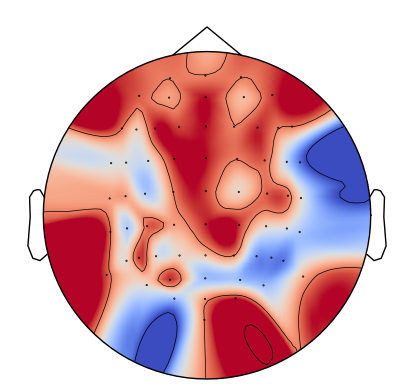

In [ ]:
################################################
########### GRAFICAMOS POR SUJETO ##############
################################################
arcs_cmap='coolwarm'
topoplot(pvalue[4],channels=Cho2017_Channels,contours=2,cmap=arcs_cmap,sphere=0.12)
plt.show()